In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from termcolor import colored as cl

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
## Create fake data, key column is fake normalised
data = {'danceability':[0.5,0.6,0.9,0.4,0.2],'energy':[0.8,0.4,0.9,0.7,0.9],'key':[0,0.4,0.8,1.0,0.3]}
data = pd.DataFrame(data)
pred_data = {'danceability':[0.7,0.4,0.7,0.8,0.4],'energy':[0.6,0.6,0.5,0.9,0.5],'key':[0.3,0.7,0.5,0.7,0.6]}
pred_data = pd.DataFrame(pred_data)

In [7]:
data = pd.read_csv('./data/data_timbre.csv')

labels = pd.DataFrame(data['order']).round(1)
columns_to_remove = ['Unnamed: 0', 'Unnamed: 0.1', 'id', 'track_title',
                    'album_artist', 'track_number', 'total_tracks', 'order',
                    'key', 'mode', 'duration_ms', 'time_signature']
data.drop(columns = columns_to_remove, axis = 1, inplace = True)

data.loc[:,['loudness', 'tempo', 'loudness_start', 'loudness_end']] = MinMaxScaler().fit_transform(data.loc[:,['loudness', 'tempo', 'loudness_start', 'loudness_end']])

current_data = pd.DataFrame(columns=data.columns)
next_data = pd.DataFrame(columns=data.columns)

for row in range(data.shape[0]-1):
    if data.iloc[row,9] == data.iloc[row+1,9]:
        current_data = current_data.append(data.iloc[row,:])
        next_data = next_data.append(data.iloc[row+1,:])

current_data.drop(columns='album_title', axis=1, inplace=True)
next_data.drop(columns='album_title', axis=1, inplace=True)

X_var = current_data.values
y_var = next_data.values

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, random_state=1)

In [50]:
# filename = 'data\data.csv'
# columns=['energy','loudness','tempo','valence', 'duration_ms', 'id', 'album_title']
# df = pd.read_csv(filename,usecols=columns)
# df2 = df.drop(columns=['id','album_title'])

# # Normalise
# x = data.values
# min_max_scaler = MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df2 = pd.DataFrame(x_scaled, columns=columns[:-2])
# title = df['album_title'][4948]
# test_train = df['album_title'] == title
# test_data = df2[test_train]
# test_labels = test_data[1:]
# test_data = test_data[:-1]

# train_data = pd.DataFrame(columns=columns[:-2])
# train_labels = pd.DataFrame(columns=columns[:-2])
# prev_title = ''
# for index,row in df2[~test_train].iterrows():
#     print(index)
#     #print('row:',row)
#     #print('prev row:',prev_row)
#     if df['album_title'][index] == prev_title:
#         train_data = train_data.append(prev_row)
#         train_labels = train_labels.append(row)
        
#     prev_title = df['album_title'][index]
#     prev_row = row

#print(train_data)
#print(train_labels)

In [55]:
## Train regression model to find each feature
# set up model
# model_energy = LinearRegression()
# model_energy.fit(train_data, train_labels['energy'])
# model_loudness = LinearRegression()
# model_loudness.fit(train_data, train_labels['loudness'])
#model_mode = LinearRegression()
#model_mode.fit(train_data, train_labels['mode'])
# model_tempo = LinearRegression()
# model_tempo.fit(train_data, train_labels['tempo'])
# model_valence = LinearRegression()
# model_valence.fit(train_data, train_labels['valence'])
# model_duration = LinearRegression()
# model_duration.fit(train_data, train_labels['duration_ms'])

# Random Forest:
rf_predict_next = ExtraTreesRegressor(n_estimators=1000).fit(X_train, y_train)
yhat = rf_predict_next.predict(X_test)
pickle.dump(rf_predict_next, open('./regression/rf_predict_next.sav', 'wb'))

print(cl('mean_squared_error of model is {}'.format(mean_squared_error(y_test, yhat)), attrs = ['bold']))
print(cl('explained_variance_score of model is {}'.format(explained_variance_score(y_test, yhat)), attrs = ['bold']))
print(cl('r2_score of model is {}'.format(r2(y_test, yhat)), attrs = ['bold']))
print(cl('mean_absolute_error of model is {}'.format(mean_absolute_error(y_test, yhat)), attrs = ['bold']))


mean_squared_error of model is 0.03369833903085635
explained_variance_score of model is 0.24057579191252224
r2_score of model is 0.23815203272668675
mean_absolute_error of model is 0.123157146617986


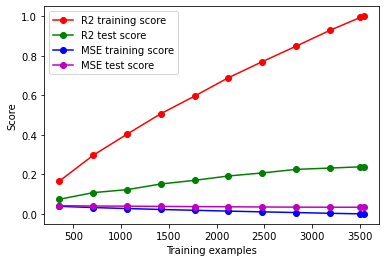

In [14]:
MSEs_Test = []
MSEs_Train = []
R2s_Test = []
R2s_Train = []
train_sizes = [round(len(X_train)*0.1), round(len(X_train)*0.2), round(len(X_train)*0.3), round(len(X_train)*0.4), round(len(X_train)*0.5),
                round(len(X_train)*0.6), round(len(X_train)*0.7), round(len(X_train)*0.8), round(len(X_train)*0.9), round(len(X_train)*0.99), round(len(X_train)*1)]

for i in range(len(train_sizes)):
    rf_predict_next = ExtraTreesRegressor(n_estimators=1000).fit(X_train[:train_sizes[i]], y_train[:train_sizes[i]])
    yhat = rf_predict_next.predict(X_test)
    y_train_hat = rf_predict_next.predict(X_train)
    MSEs_Test.append(mean_squared_error(y_test, yhat))
    MSEs_Train.append(mean_squared_error(y_train, y_train_hat))
    R2s_Test.append(r2(y_test, yhat))
    R2s_Train.append(r2(y_train, y_train_hat))

_, axes = plt.subplots(figsize=[6,4])
axes.plot(train_sizes, R2s_Train, "o-", color="r", label="R2 training score")
axes.plot(train_sizes, R2s_Test, "o-", color="g", label="R2 test score")
axes.plot(train_sizes, MSEs_Train, "o-", color="b", label="MSE training score")
axes.plot(train_sizes, MSEs_Test, "o-", color="m", label="MSE test score")
axes.legend(loc='best')
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
plt.show()

In [ ]:
# ## Predicting next features for an unseen album
# prediction = []
# # prediction.append(model_energy.predict(test_data))
# print("Energy mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['energy']))
# prediction.append(model_loudness.predict(test_data))
# print("Loudness mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['loudness']))
# #prediction.append(model_mode.predict(test_data))
# #print("Mode mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['mode']))
# prediction.append(model_tempo.predict(test_data))
# print("Tempo mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['tempo']))
# prediction.append(model_valence.predict(test_data))
# print("Valence mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['valence']))
# prediction.append(model_duration.predict(test_data))
# print("Duration mean squared error: %.2f" % mean_squared_error(prediction[-1], test_labels['duration_ms']))

In [61]:
## Find distances for all songs
#it dont work
#columns=['danceability','energy','key']
test_data.reset_index(drop=True,inplace=True)
dist = np.empty((len(prediction[0]),len(prediction[0]-1)))
prediction = np.array(prediction)
print(prediction[:,0])
for index in range(len(prediction[0])):
    #dist = pd.DataFrame(columns=columns)
    row = prediction[:,index]
    #print(row)
    for i, r in test_data.iterrows():
        #print(i,index)
        if index == i:
            dist[index][i] = np.inf
            #print('same song')
            continue
        
        # print((row-r))#**0.5)
        # print(sum((row-r)**2)**0.5)
        dist[index][i] = (sum((row-r)**2)**0.5)
        #print(sum((row-r)**2)**0.5)
    #print(dist)
print(dist)

[0.5795579  0.73692142 0.3714114  0.4780889  0.08693415]
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 4
15 4
16 4
17 4
18 4
19 4
20 4
21 4
22 4
23 4
24 4
25 4
26 4
27 4
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
11 5
12 5
13 5
14 5
15 5
16 5
17 5
18 5
19 5
20 5
21 5
22 5
23 5
24 5
25 5
26 5
27 5
0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
11 6
12 6
13 6
14 6
15 6
16 6
17 6
18 6
19 6
20 6
21 6
22 6
23 6
24 6
25 6
26 6
27 6
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8

In [62]:
# simple pairing
alter_dist = dist
playlist = [0]
alter_dist[:,playlist[-1]] = np.inf
for i in range(len(dist[:,0])):
    #print(alter_dist)
    playlist.append(np.argmin(alter_dist[playlist[-1]]))
    alter_dist[:,playlist[-1]] = np.inf
    
print(playlist)


[0, 15, 6, 21, 17, 2, 23, 25, 10, 26, 16, 1, 7, 27, 12, 8, 22, 11, 19, 4, 13, 14, 20, 5, 24, 9, 3, 18, 0]


In [63]:
# optimising pairing
alter_dist = dist
playlist=[0]
for i in range(len(dist[:,0])):
    playlist.append(np.argmin(alter_dist[playlist[-1]]))

playlist

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]